# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [5]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.09081995087e-10
dw error:  2.17524920521e-10
db error:  1.88100311196e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27563491363e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.7505621216e-11
dw error:  8.16201557044e-11
db error:  7.82672402146e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.9996027491
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.3025458445
dx error:  9.38467316199e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.45e-10
b1 relative error: 8.01e-09
b2 relative error: 2.53e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 1.37e-07
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [6]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()

In [12]:
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [13]:
np.random.seed(42)
model = TwoLayerNet(input_dim=3*32*32, hidden_dim=100, num_classes=10,
                    weight_scale=1e-3, reg=.5)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
optim_config = {'learning_rate' : 0.001}
solver = Solver(model, data, 
                update_rule='sgd', 
                optim_config=optim_config,
                lr_decay=0.9,
                batch_size=100,
                num_epochs=7,
                print_every=10,
                verbose=True,
                num_train_samples=1000,
                num_val_samples=None,
                checkpoint_name=None
                )

solver.check_accuracy(data['X_val'], data['y_val'])
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 3430) loss: 2.380213
(Epoch 0 / 7) train acc: 0.152000; val_acc: 0.138000
(Iteration 11 / 3430) loss: 2.312872
(Iteration 21 / 3430) loss: 2.192203
(Iteration 31 / 3430) loss: 2.164225
(Iteration 41 / 3430) loss: 2.047471
(Iteration 51 / 3430) loss: 2.002042
(Iteration 61 / 3430) loss: 1.939005
(Iteration 71 / 3430) loss: 2.005185
(Iteration 81 / 3430) loss: 2.001067
(Iteration 91 / 3430) loss: 1.981097
(Iteration 101 / 3430) loss: 1.793886
(Iteration 111 / 3430) loss: 1.950822
(Iteration 121 / 3430) loss: 1.840858
(Iteration 131 / 3430) loss: 1.892048
(Iteration 141 / 3430) loss: 1.817498
(Iteration 151 / 3430) loss: 1.898141
(Iteration 161 / 3430) loss: 1.569572
(Iteration 171 / 3430) loss: 1.972130
(Iteration 181 / 3430) loss: 1.848052
(Iteration 191 / 3430) loss: 1.792608
(Iteration 201 / 3430) loss: 1.801018
(Iteration 211 / 3430) loss: 1.769810
(Iteration 221 / 3430) loss: 1.735559
(Iteration 231 / 3430) loss: 1.582786
(Iteration 241 / 3430) loss: 1.814702
(Iterati

(Iteration 2081 / 3430) loss: 1.399014
(Iteration 2091 / 3430) loss: 1.446350
(Iteration 2101 / 3430) loss: 1.543305
(Iteration 2111 / 3430) loss: 1.530369
(Iteration 2121 / 3430) loss: 1.571852
(Iteration 2131 / 3430) loss: 1.374324
(Iteration 2141 / 3430) loss: 1.464107
(Iteration 2151 / 3430) loss: 1.512422
(Iteration 2161 / 3430) loss: 1.493344
(Iteration 2171 / 3430) loss: 1.520328
(Iteration 2181 / 3430) loss: 1.374537
(Iteration 2191 / 3430) loss: 1.478839
(Iteration 2201 / 3430) loss: 1.454138
(Iteration 2211 / 3430) loss: 1.564774
(Iteration 2221 / 3430) loss: 1.540034
(Iteration 2231 / 3430) loss: 1.427767
(Iteration 2241 / 3430) loss: 1.639586
(Iteration 2251 / 3430) loss: 1.432763
(Iteration 2261 / 3430) loss: 1.397325
(Iteration 2271 / 3430) loss: 1.575275
(Iteration 2281 / 3430) loss: 1.452298
(Iteration 2291 / 3430) loss: 1.537073
(Iteration 2301 / 3430) loss: 1.536839
(Iteration 2311 / 3430) loss: 1.649961
(Iteration 2321 / 3430) loss: 1.347402
(Iteration 2331 / 3430) l

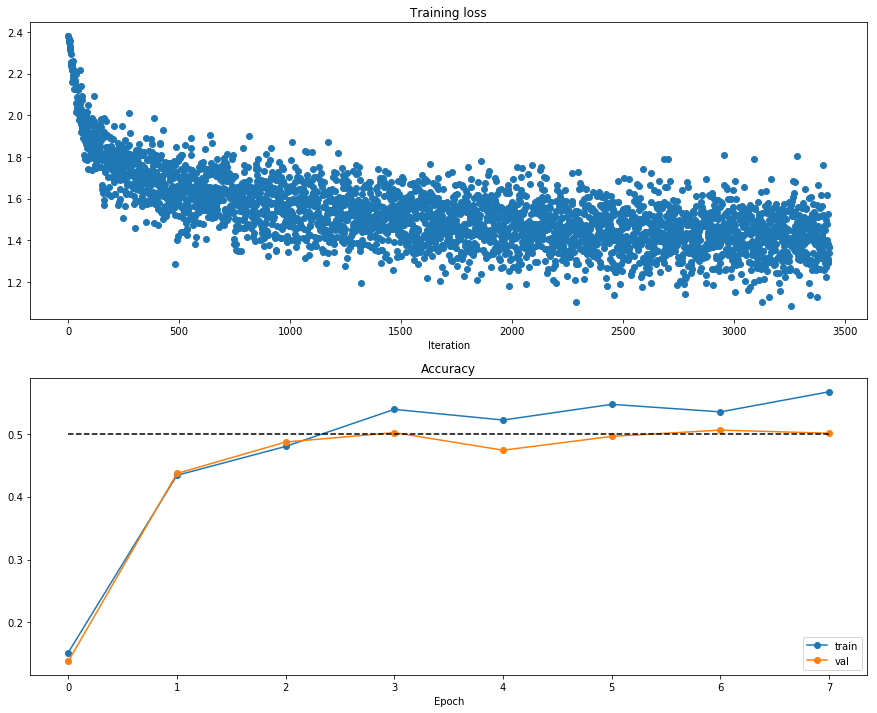

In [14]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [37]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30047908977
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.05211477653
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 3.019663
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.132000
(Epoch 1 / 20) train acc: 0.340000; val_acc: 0.143000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.126000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.129000
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.151000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.142000
(Iteration 11 / 40) loss: 0.885081
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.158000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.146000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.152000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.144000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.149000
(Iteration 21 / 40) loss: 0.359596
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.143000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.141000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.140000
(Iteration 31 / 40) loss: 

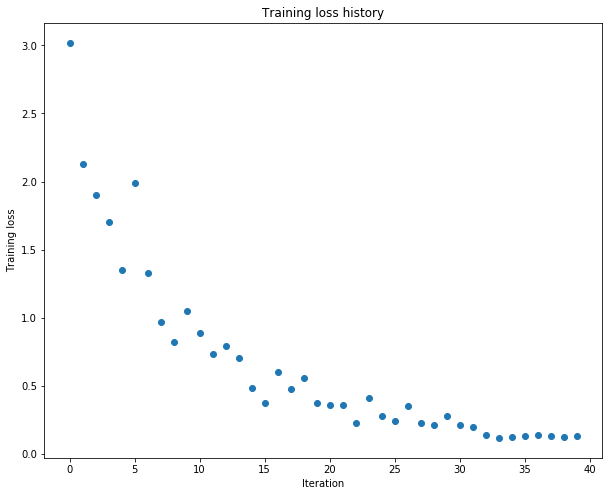

In [49]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
learning_rate = 2e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 97.260761
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.085000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.106000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.102000
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.112000
(Epoch 4 / 20) train acc: 0.780000; val_acc: 0.123000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.131000
(Iteration 11 / 40) loss: 2.391065
(Epoch 6 / 20) train acc: 0.920000; val_acc: 0.122000
(Epoch 7 / 20) train acc: 0.900000; val_acc: 0.115000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.121000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.115000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.114000
(Iteration 21 / 40) loss: 0.001274
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.115000
(Iteration 31 / 40) loss:

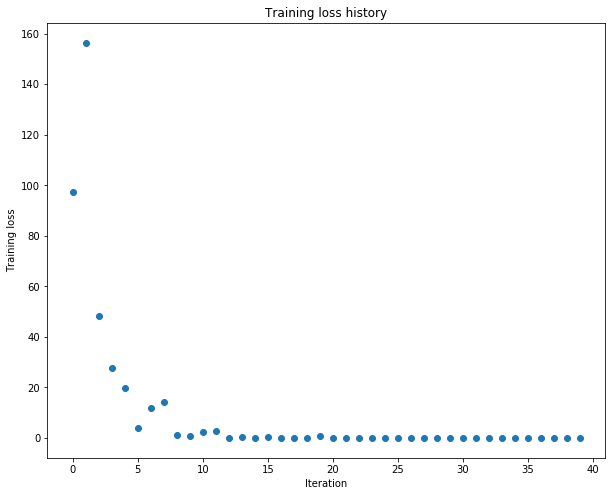

In [50]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 1e-1
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
I found the five-layer net much more willing to overfit the data. This is presumably because it has more parameters with which it can do so. They offer a greater range of freedom to fit the data very closely.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [13]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.668315
(Epoch 0 / 5) train acc: 0.089000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.112464
(Iteration 21 / 200) loss: 2.136812
(Iteration 31 / 200) loss: 1.999070
(Epoch 1 / 5) train acc: 0.296000; val_acc: 0.266000
(Iteration 41 / 200) loss: 1.936422
(Iteration 51 / 200) loss: 2.054836
(Iteration 61 / 200) loss: 2.029425
(Iteration 71 / 200) loss: 1.883343
(Epoch 2 / 5) train acc: 0.344000; val_acc: 0.317000
(Iteration 81 / 200) loss: 1.940587
(Iteration 91 / 200) loss: 1.818649
(Iteration 101 / 200) loss: 1.910825
(Iteration 111 / 200) loss: 1.861045
(Epoch 3 / 5) train acc: 0.389000; val_acc: 0.301000
(Iteration 121 / 200) loss: 1.865519
(Iteration 131 / 200) loss: 1.860086
(Iteration 141 / 200) loss: 1.891190
(Iteration 151 / 200) loss: 1.906999
(Epoch 4 / 5) train acc: 0.384000; val_acc: 0.313000
(Iteration 161 / 200) loss: 1.873975
(Iteration 171 / 200) loss: 1.722382
(Iteration 181 / 200) loss: 1.606829
(Iteration 191 / 200) los

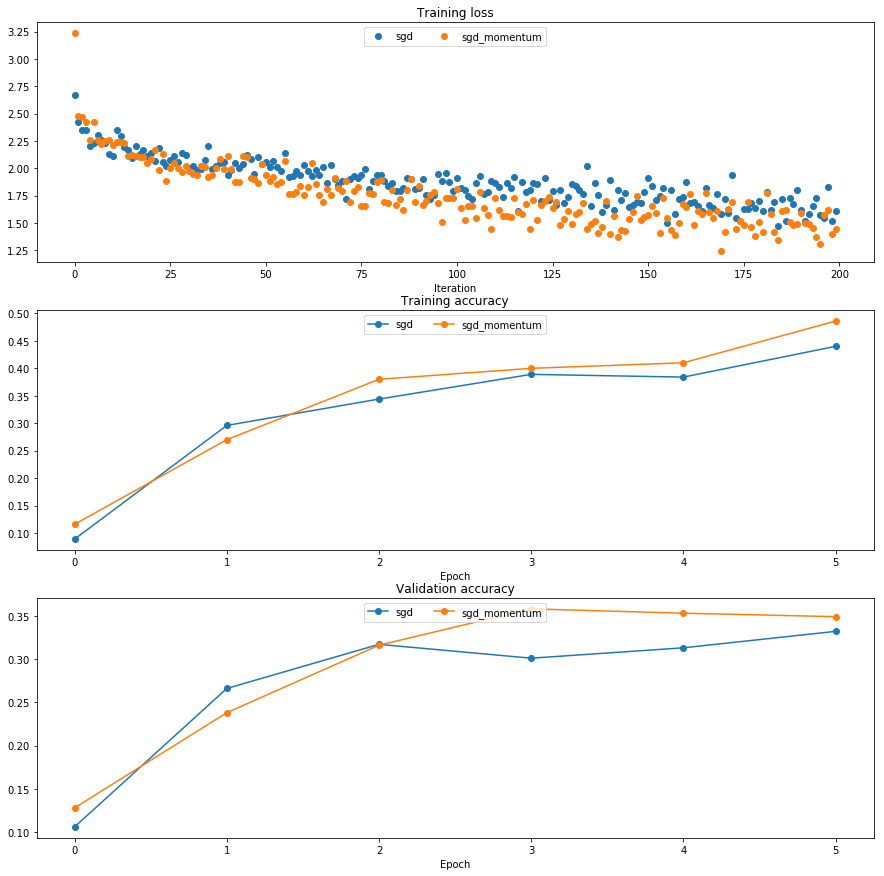

In [14]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [17]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [50]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 2.736807
(Epoch 0 / 5) train acc: 0.133000; val_acc: 0.121000
(Iteration 11 / 200) loss: 2.086692
(Iteration 21 / 200) loss: 1.846555
(Iteration 31 / 200) loss: 1.830887
(Epoch 1 / 5) train acc: 0.352000; val_acc: 0.289000
(Iteration 41 / 200) loss: 1.948171
(Iteration 51 / 200) loss: 1.615705
(Iteration 61 / 200) loss: 1.670913
(Iteration 71 / 200) loss: 1.685762
(Epoch 2 / 5) train acc: 0.435000; val_acc: 0.357000
(Iteration 81 / 200) loss: 1.703015
(Iteration 91 / 200) loss: 1.480732
(Iteration 101 / 200) loss: 1.463452
(Iteration 111 / 200) loss: 1.656195
(Epoch 3 / 5) train acc: 0.503000; val_acc: 0.388000
(Iteration 121 / 200) loss: 1.489446
(Iteration 131 / 200) loss: 1.365818
(Iteration 141 / 200) loss: 1.233379
(Iteration 151 / 200) loss: 1.269656
(Epoch 4 / 5) train acc: 0.522000; val_acc: 0.371000
(Iteration 161 / 200) loss: 1.178110
(Iteration 171 / 200) loss: 1.357445
(Iteration 181 / 200) loss: 1.446208
(Iteration 191 / 200) lo

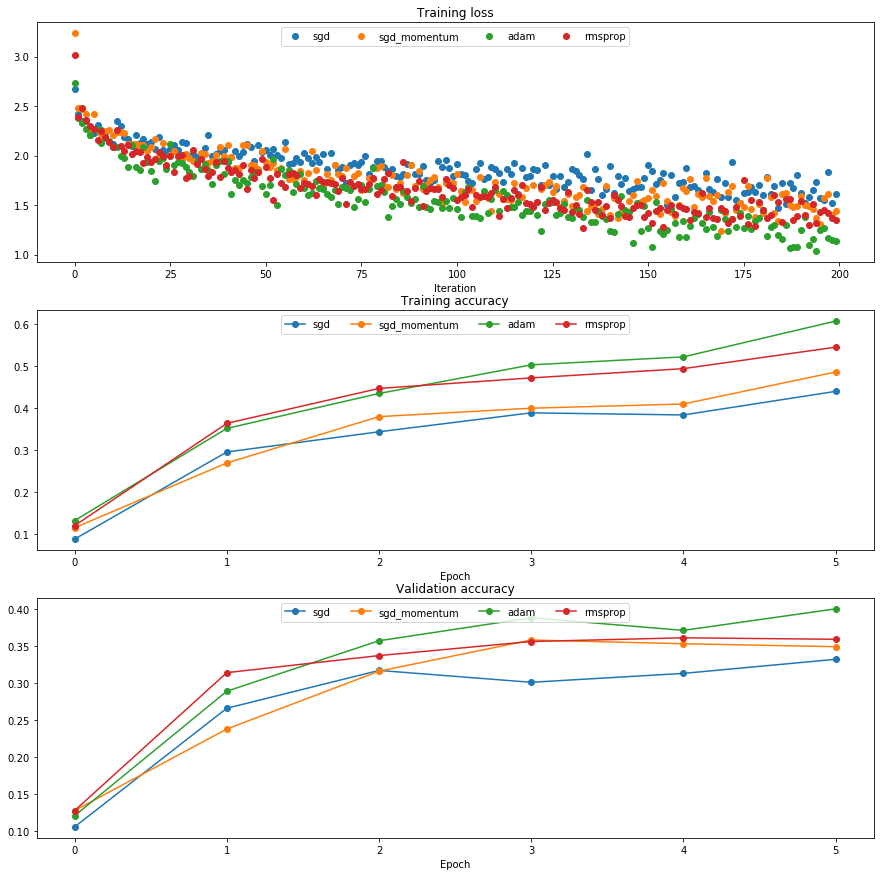

In [51]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [49]:
from numpy.random import uniform, randint

best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
results = {}
models = []
solvers = []
best_val_acc = -1

max_count = 35
for i in range(max_count):
    learning_rate = 10**uniform(-4, -3)
    lr_decay = uniform(0.9, 1)
    reg_strength = 10**uniform(-6, -4.5)
    weight_scale = 10**uniform(-5, -3.2)
    hidden_dim_size = 100
    n_hidden_dims = randint(2,6)
    dropout = uniform(0, 0.5)
    
    print('Run %d out of %d' % (i + 1, max_count))
    model = FullyConnectedNet([hidden_dim_size] * n_hidden_dims,
                              input_dim=3*32*32, num_classes=10,
                              dropout=dropout, use_batchnorm=True, reg=reg_strength,
                              weight_scale=weight_scale, dtype=np.float32, seed=None)
    
    solver = Solver(model, data,
                    num_epochs=50, batch_size=100,
                    lr_decay=lr_decay,
                    update_rule='adam',
                    verbose=False,
                    optim_config={
                        'learning_rate': learning_rate,
                    })
                    
        
    solver.train()
    val_acc = solver.best_val_acc
    if val_acc > best_val_acc:
        best_model = model
        best_val_acc = val_acc
    solvers.append(solver)
    
    print('lr: %.2e lr_dec %.2e reg %.2e weight_s: %.2e h_dim %d n_hid %d drop %.2f VAL ACCURACY: %.2f' % (
                learning_rate, lr_decay, reg_strength, weight_scale, hidden_dim_size, n_hidden_dims, dropout, val_acc))
    
    results[(learning_rate, lr_decay, reg_strength, weight_scale, hidden_dim_size,
            n_hidden_dims, dropout)] = val_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Run 1 out of 35
lr: 1.74e-04 lr_dec 9.09e-01 reg 1.80e-06 weight_s: 2.75e-05 h_dim 100 n_hid 3 drop 0.25 VAL ACCURACY: 0.57
Run 2 out of 35
lr: 2.26e-04 lr_dec 9.32e-01 reg 1.54e-06 weight_s: 5.21e-04 h_dim 100 n_hid 5 drop 0.45 VAL ACCURACY: 0.50
Run 3 out of 35
lr: 3.30e-04 lr_dec 9.78e-01 reg 3.79e-06 weight_s: 4.14e-05 h_dim 100 n_hid 2 drop 0.12 VAL ACCURACY: 0.57
Run 4 out of 35
lr: 1.53e-04 lr_dec 9.48e-01 reg 1.19e-06 weight_s: 2.10e-05 h_dim 100 n_hid 5 drop 0.15 VAL ACCURACY: 0.57
Run 5 out of 35
lr: 1.76e-04 lr_dec 9.16e-01 reg 1.37e-05 weight_s: 2.43e-04 h_dim 100 n_hid 3 drop 0.10 VAL ACCURACY: 0.59
Run 6 out of 35
lr: 1.35e-04 lr_dec 9.99e-01 reg 1.34e-06 weight_s: 2.29e-05 h_dim 100 n_hid 4 drop 0.20 VAL ACCURACY: 0.57
Run 7 out of 35
lr: 8.72e-04 lr_dec 9.97e-01 reg 2.26e-06 weight_s: 1.10e-04 h_dim 100 n_hid 3 drop 0.47 VAL ACCURACY: 0.54
Run 8 out of 35
lr: 5.91e-04 lr_dec 9.97e-01 reg 3.15e-05 weight_s: 1.21e-05 h_dim 100 n_hid 5 drop 0.25 VAL ACCURACY: 0.57
Run 9 ou

In [50]:
for run in sorted(results.items(), key=lambda x:x[1], reverse=True):
    lr, lr_decay, reg, ws, hidden_dim_size, n_hidden_dims, dropout = run[0]
    val_acc = run[1]
    print('lr: %.2e lr_dec %.2e reg %.2e weight_s: %.2e h_dim %d n_hid %d drop %.2f VAL ACCURACY: %.2f' % (
                lr, lr_decay, reg, ws, hidden_dim_size, n_hidden_dims, dropout, val_acc))
    

lr: 1.76e-04 lr_dec 9.16e-01 reg 1.37e-05 weight_s: 2.43e-04 h_dim 100 n_hid 3 drop 0.10 VAL ACCURACY: 0.59
lr: 6.85e-04 lr_dec 9.18e-01 reg 3.51e-06 weight_s: 4.94e-05 h_dim 100 n_hid 3 drop 0.24 VAL ACCURACY: 0.58
lr: 1.67e-04 lr_dec 9.47e-01 reg 1.32e-06 weight_s: 2.24e-05 h_dim 100 n_hid 4 drop 0.08 VAL ACCURACY: 0.58
lr: 1.51e-04 lr_dec 9.47e-01 reg 1.12e-06 weight_s: 2.75e-05 h_dim 100 n_hid 5 drop 0.18 VAL ACCURACY: 0.58
lr: 1.53e-04 lr_dec 9.48e-01 reg 1.19e-06 weight_s: 2.10e-05 h_dim 100 n_hid 5 drop 0.15 VAL ACCURACY: 0.57
lr: 1.81e-04 lr_dec 9.45e-01 reg 1.44e-06 weight_s: 4.41e-04 h_dim 100 n_hid 3 drop 0.16 VAL ACCURACY: 0.57
lr: 8.74e-04 lr_dec 9.90e-01 reg 3.72e-06 weight_s: 5.88e-05 h_dim 100 n_hid 3 drop 0.20 VAL ACCURACY: 0.57
lr: 1.35e-04 lr_dec 9.99e-01 reg 1.34e-06 weight_s: 2.29e-05 h_dim 100 n_hid 4 drop 0.20 VAL ACCURACY: 0.57
lr: 5.70e-04 lr_dec 9.64e-01 reg 1.72e-05 weight_s: 1.88e-05 h_dim 100 n_hid 4 drop 0.23 VAL ACCURACY: 0.57
lr: 6.81e-04 lr_dec 9.37e-01

In [8]:
# Best model:
# 55.8% on test set, and 58.6% on validation set
learning_rate = 1.76e-04
lr_decay = 9.16e-01
reg_strength = 1.37e-05
weight_scale = 2.43e-04
hidden_dim_size = 100
n_hidden_dims = 3
dropout = 0.1

model = FullyConnectedNet([hidden_dim_size] * n_hidden_dims,
                      input_dim=3*32*32, num_classes=10,
                      dropout=dropout, use_batchnorm=True, reg=reg_strength,
                      weight_scale=weight_scale, dtype=np.float32, seed=None)
solver = Solver(model, data,
                num_epochs=50, batch_size=100,
                lr_decay=lr_decay,
                update_rule='adam',
                verbose=True,
                optim_config={
                    'learning_rate': learning_rate,
                })            
solver.train()

(Iteration 1 / 98000) loss: 2.302599
(Epoch 0 / 200) train acc: 0.111000; val_acc: 0.130000
(Iteration 11 / 98000) loss: 2.277334
(Iteration 21 / 98000) loss: 2.235897
(Iteration 31 / 98000) loss: 2.199499
(Iteration 41 / 98000) loss: 2.149068
(Iteration 51 / 98000) loss: 2.110655
(Iteration 61 / 98000) loss: 2.139409
(Iteration 71 / 98000) loss: 2.164183
(Iteration 81 / 98000) loss: 2.057961
(Iteration 91 / 98000) loss: 2.040533
(Iteration 101 / 98000) loss: 2.075819
(Iteration 111 / 98000) loss: 2.013991
(Iteration 121 / 98000) loss: 2.011798
(Iteration 131 / 98000) loss: 1.944024
(Iteration 141 / 98000) loss: 1.919884
(Iteration 151 / 98000) loss: 1.972478
(Iteration 161 / 98000) loss: 1.933699
(Iteration 171 / 98000) loss: 1.863749
(Iteration 181 / 98000) loss: 1.910989
(Iteration 191 / 98000) loss: 1.920299
(Iteration 201 / 98000) loss: 1.927042
(Iteration 211 / 98000) loss: 1.911488
(Iteration 221 / 98000) loss: 1.947204
(Iteration 231 / 98000) loss: 1.889710
(Iteration 241 / 980

(Iteration 2011 / 98000) loss: 1.505512
(Iteration 2021 / 98000) loss: 1.368628
(Iteration 2031 / 98000) loss: 1.635279
(Iteration 2041 / 98000) loss: 1.340903
(Iteration 2051 / 98000) loss: 1.393541
(Iteration 2061 / 98000) loss: 1.327505
(Iteration 2071 / 98000) loss: 1.385071
(Iteration 2081 / 98000) loss: 1.569813
(Iteration 2091 / 98000) loss: 1.261554
(Iteration 2101 / 98000) loss: 1.380391
(Iteration 2111 / 98000) loss: 1.425662
(Iteration 2121 / 98000) loss: 1.577889
(Iteration 2131 / 98000) loss: 1.384012
(Iteration 2141 / 98000) loss: 1.281938
(Iteration 2151 / 98000) loss: 1.354223
(Iteration 2161 / 98000) loss: 1.286539
(Iteration 2171 / 98000) loss: 1.202927
(Iteration 2181 / 98000) loss: 1.393943
(Iteration 2191 / 98000) loss: 1.485727
(Iteration 2201 / 98000) loss: 1.268652
(Iteration 2211 / 98000) loss: 1.294067
(Iteration 2221 / 98000) loss: 1.618923
(Iteration 2231 / 98000) loss: 1.401113
(Iteration 2241 / 98000) loss: 1.288276
(Iteration 2251 / 98000) loss: 1.407051


(Iteration 4021 / 98000) loss: 1.290903
(Iteration 4031 / 98000) loss: 1.030542
(Iteration 4041 / 98000) loss: 1.137715
(Iteration 4051 / 98000) loss: 1.361007
(Iteration 4061 / 98000) loss: 1.357768
(Iteration 4071 / 98000) loss: 1.370333
(Iteration 4081 / 98000) loss: 1.065451
(Iteration 4091 / 98000) loss: 1.552889
(Iteration 4101 / 98000) loss: 1.231685
(Iteration 4111 / 98000) loss: 1.259432
(Iteration 4121 / 98000) loss: 1.378735
(Iteration 4131 / 98000) loss: 1.107849
(Iteration 4141 / 98000) loss: 1.113539
(Iteration 4151 / 98000) loss: 1.390118
(Iteration 4161 / 98000) loss: 1.416544
(Iteration 4171 / 98000) loss: 1.277591
(Iteration 4181 / 98000) loss: 1.342581
(Iteration 4191 / 98000) loss: 1.319574
(Iteration 4201 / 98000) loss: 1.326243
(Iteration 4211 / 98000) loss: 1.256422
(Iteration 4221 / 98000) loss: 1.155608
(Iteration 4231 / 98000) loss: 1.240227
(Iteration 4241 / 98000) loss: 1.195373
(Iteration 4251 / 98000) loss: 1.165948
(Iteration 4261 / 98000) loss: 1.263093


(Iteration 6021 / 98000) loss: 1.467145
(Iteration 6031 / 98000) loss: 1.095432
(Iteration 6041 / 98000) loss: 1.231950
(Iteration 6051 / 98000) loss: 1.199632
(Iteration 6061 / 98000) loss: 1.260111
(Iteration 6071 / 98000) loss: 1.094939
(Iteration 6081 / 98000) loss: 1.174344
(Iteration 6091 / 98000) loss: 1.391129
(Iteration 6101 / 98000) loss: 1.139441
(Iteration 6111 / 98000) loss: 1.081320
(Iteration 6121 / 98000) loss: 1.253202
(Iteration 6131 / 98000) loss: 1.276076
(Iteration 6141 / 98000) loss: 1.011213
(Iteration 6151 / 98000) loss: 1.176539
(Iteration 6161 / 98000) loss: 1.252578
(Iteration 6171 / 98000) loss: 1.104304
(Iteration 6181 / 98000) loss: 1.025081
(Iteration 6191 / 98000) loss: 1.399237
(Iteration 6201 / 98000) loss: 1.259331
(Iteration 6211 / 98000) loss: 1.233475
(Iteration 6221 / 98000) loss: 1.182467
(Iteration 6231 / 98000) loss: 0.988828
(Iteration 6241 / 98000) loss: 1.108457
(Iteration 6251 / 98000) loss: 1.274425
(Iteration 6261 / 98000) loss: 1.237107


(Iteration 8021 / 98000) loss: 1.091068
(Iteration 8031 / 98000) loss: 1.163543
(Iteration 8041 / 98000) loss: 1.223498
(Iteration 8051 / 98000) loss: 1.117203
(Iteration 8061 / 98000) loss: 1.034836
(Iteration 8071 / 98000) loss: 1.128372
(Iteration 8081 / 98000) loss: 1.248693
(Iteration 8091 / 98000) loss: 1.249663
(Iteration 8101 / 98000) loss: 1.104258
(Iteration 8111 / 98000) loss: 0.995437
(Iteration 8121 / 98000) loss: 1.051131
(Iteration 8131 / 98000) loss: 1.116043
(Iteration 8141 / 98000) loss: 1.248584
(Iteration 8151 / 98000) loss: 1.133159
(Iteration 8161 / 98000) loss: 1.066814
(Iteration 8171 / 98000) loss: 1.198486
(Iteration 8181 / 98000) loss: 1.311063
(Iteration 8191 / 98000) loss: 1.028691
(Iteration 8201 / 98000) loss: 1.342713
(Iteration 8211 / 98000) loss: 1.069101
(Iteration 8221 / 98000) loss: 1.122518
(Iteration 8231 / 98000) loss: 1.143948
(Iteration 8241 / 98000) loss: 1.060873
(Iteration 8251 / 98000) loss: 1.158822
(Iteration 8261 / 98000) loss: 1.201434


(Iteration 10021 / 98000) loss: 1.022458
(Iteration 10031 / 98000) loss: 1.201721
(Iteration 10041 / 98000) loss: 1.172621
(Iteration 10051 / 98000) loss: 1.020961
(Iteration 10061 / 98000) loss: 1.092995
(Iteration 10071 / 98000) loss: 1.213052
(Iteration 10081 / 98000) loss: 1.265056
(Iteration 10091 / 98000) loss: 1.161017
(Iteration 10101 / 98000) loss: 1.221991
(Iteration 10111 / 98000) loss: 1.057617
(Iteration 10121 / 98000) loss: 1.265028
(Iteration 10131 / 98000) loss: 1.193530
(Iteration 10141 / 98000) loss: 1.160371
(Iteration 10151 / 98000) loss: 1.197268
(Iteration 10161 / 98000) loss: 1.079880
(Iteration 10171 / 98000) loss: 1.238732
(Iteration 10181 / 98000) loss: 1.038447
(Iteration 10191 / 98000) loss: 1.108916
(Iteration 10201 / 98000) loss: 0.943283
(Iteration 10211 / 98000) loss: 1.196743
(Iteration 10221 / 98000) loss: 1.044891
(Iteration 10231 / 98000) loss: 1.223175
(Iteration 10241 / 98000) loss: 1.059960
(Iteration 10251 / 98000) loss: 1.078542
(Iteration 10261

(Iteration 11981 / 98000) loss: 1.358281
(Iteration 11991 / 98000) loss: 1.082961
(Iteration 12001 / 98000) loss: 0.923279
(Iteration 12011 / 98000) loss: 1.041640
(Iteration 12021 / 98000) loss: 0.962033
(Iteration 12031 / 98000) loss: 0.917555
(Iteration 12041 / 98000) loss: 1.153155
(Iteration 12051 / 98000) loss: 0.992149
(Iteration 12061 / 98000) loss: 1.130411
(Iteration 12071 / 98000) loss: 0.995665
(Iteration 12081 / 98000) loss: 1.276393
(Iteration 12091 / 98000) loss: 1.072372
(Iteration 12101 / 98000) loss: 1.114787
(Iteration 12111 / 98000) loss: 0.994027
(Iteration 12121 / 98000) loss: 0.944043
(Iteration 12131 / 98000) loss: 1.012013
(Iteration 12141 / 98000) loss: 1.057750
(Iteration 12151 / 98000) loss: 1.048866
(Iteration 12161 / 98000) loss: 1.114488
(Iteration 12171 / 98000) loss: 0.914775
(Iteration 12181 / 98000) loss: 1.094486
(Iteration 12191 / 98000) loss: 1.048490
(Iteration 12201 / 98000) loss: 0.990094
(Iteration 12211 / 98000) loss: 1.044165
(Iteration 12221

(Iteration 13941 / 98000) loss: 0.856949
(Iteration 13951 / 98000) loss: 1.159017
(Iteration 13961 / 98000) loss: 1.169573
(Iteration 13971 / 98000) loss: 1.044833
(Iteration 13981 / 98000) loss: 1.010761
(Iteration 13991 / 98000) loss: 0.865331
(Iteration 14001 / 98000) loss: 1.122696
(Iteration 14011 / 98000) loss: 1.003111
(Iteration 14021 / 98000) loss: 1.250578
(Iteration 14031 / 98000) loss: 0.994642
(Iteration 14041 / 98000) loss: 0.825248
(Iteration 14051 / 98000) loss: 1.155532
(Iteration 14061 / 98000) loss: 0.954590
(Iteration 14071 / 98000) loss: 1.189770
(Iteration 14081 / 98000) loss: 1.058193
(Iteration 14091 / 98000) loss: 0.934404
(Iteration 14101 / 98000) loss: 0.995602
(Iteration 14111 / 98000) loss: 0.957938
(Iteration 14121 / 98000) loss: 0.992581
(Iteration 14131 / 98000) loss: 1.147826
(Iteration 14141 / 98000) loss: 1.089133
(Iteration 14151 / 98000) loss: 1.025812
(Iteration 14161 / 98000) loss: 1.130982
(Iteration 14171 / 98000) loss: 1.039216
(Iteration 14181

(Iteration 15901 / 98000) loss: 0.972667
(Iteration 15911 / 98000) loss: 1.071124
(Iteration 15921 / 98000) loss: 1.019303
(Iteration 15931 / 98000) loss: 0.888212
(Iteration 15941 / 98000) loss: 0.940336
(Iteration 15951 / 98000) loss: 0.925652
(Iteration 15961 / 98000) loss: 1.166648
(Iteration 15971 / 98000) loss: 1.142206
(Iteration 15981 / 98000) loss: 1.204645
(Iteration 15991 / 98000) loss: 1.182883
(Iteration 16001 / 98000) loss: 1.097855
(Iteration 16011 / 98000) loss: 1.096043
(Iteration 16021 / 98000) loss: 1.069163
(Iteration 16031 / 98000) loss: 1.418174
(Iteration 16041 / 98000) loss: 1.228751
(Iteration 16051 / 98000) loss: 1.124223
(Iteration 16061 / 98000) loss: 1.057488
(Iteration 16071 / 98000) loss: 1.043778
(Iteration 16081 / 98000) loss: 0.892786
(Iteration 16091 / 98000) loss: 1.046526
(Iteration 16101 / 98000) loss: 0.994862
(Iteration 16111 / 98000) loss: 1.111783
(Iteration 16121 / 98000) loss: 0.842571
(Iteration 16131 / 98000) loss: 1.072498
(Iteration 16141

(Iteration 17861 / 98000) loss: 1.063509
(Iteration 17871 / 98000) loss: 1.040546
(Iteration 17881 / 98000) loss: 1.095989
(Iteration 17891 / 98000) loss: 0.992096
(Iteration 17901 / 98000) loss: 0.868213
(Iteration 17911 / 98000) loss: 1.132566
(Iteration 17921 / 98000) loss: 1.019681
(Iteration 17931 / 98000) loss: 0.986201
(Iteration 17941 / 98000) loss: 1.340046
(Iteration 17951 / 98000) loss: 0.861134
(Iteration 17961 / 98000) loss: 0.947786
(Iteration 17971 / 98000) loss: 0.899112
(Iteration 17981 / 98000) loss: 1.035311
(Iteration 17991 / 98000) loss: 0.929501
(Iteration 18001 / 98000) loss: 1.124055
(Iteration 18011 / 98000) loss: 1.115539
(Iteration 18021 / 98000) loss: 1.016388
(Iteration 18031 / 98000) loss: 1.212840
(Iteration 18041 / 98000) loss: 1.071141
(Iteration 18051 / 98000) loss: 1.284462
(Iteration 18061 / 98000) loss: 1.062149
(Iteration 18071 / 98000) loss: 1.064923
(Iteration 18081 / 98000) loss: 1.092513
(Iteration 18091 / 98000) loss: 1.182608
(Iteration 18101

(Iteration 19821 / 98000) loss: 1.025580
(Iteration 19831 / 98000) loss: 1.081112
(Iteration 19841 / 98000) loss: 1.028031
(Iteration 19851 / 98000) loss: 1.062231
(Iteration 19861 / 98000) loss: 1.067001
(Iteration 19871 / 98000) loss: 0.867731
(Iteration 19881 / 98000) loss: 1.106559
(Iteration 19891 / 98000) loss: 0.938843
(Iteration 19901 / 98000) loss: 1.093549
(Iteration 19911 / 98000) loss: 1.012216
(Iteration 19921 / 98000) loss: 0.929225
(Iteration 19931 / 98000) loss: 1.042954
(Iteration 19941 / 98000) loss: 1.061077
(Iteration 19951 / 98000) loss: 0.960966
(Iteration 19961 / 98000) loss: 1.003976
(Iteration 19971 / 98000) loss: 0.973662
(Iteration 19981 / 98000) loss: 0.793700
(Iteration 19991 / 98000) loss: 0.987413
(Iteration 20001 / 98000) loss: 1.010431
(Iteration 20011 / 98000) loss: 0.966031
(Iteration 20021 / 98000) loss: 0.828283
(Iteration 20031 / 98000) loss: 1.125542
(Iteration 20041 / 98000) loss: 1.063226
(Iteration 20051 / 98000) loss: 0.855402
(Iteration 20061

(Iteration 21781 / 98000) loss: 0.904587
(Iteration 21791 / 98000) loss: 1.076982
(Iteration 21801 / 98000) loss: 0.949664
(Iteration 21811 / 98000) loss: 1.030867
(Iteration 21821 / 98000) loss: 1.138746
(Iteration 21831 / 98000) loss: 0.842969
(Iteration 21841 / 98000) loss: 1.140605
(Iteration 21851 / 98000) loss: 1.021720
(Iteration 21861 / 98000) loss: 0.973088
(Iteration 21871 / 98000) loss: 1.134491
(Iteration 21881 / 98000) loss: 0.965240
(Iteration 21891 / 98000) loss: 1.055216
(Iteration 21901 / 98000) loss: 1.223002
(Iteration 21911 / 98000) loss: 1.106254
(Iteration 21921 / 98000) loss: 0.969486
(Iteration 21931 / 98000) loss: 1.039094
(Iteration 21941 / 98000) loss: 1.355094
(Iteration 21951 / 98000) loss: 1.174255
(Iteration 21961 / 98000) loss: 1.029563
(Iteration 21971 / 98000) loss: 0.896890
(Iteration 21981 / 98000) loss: 0.881386
(Iteration 21991 / 98000) loss: 1.025473
(Iteration 22001 / 98000) loss: 0.942394
(Iteration 22011 / 98000) loss: 0.967692
(Iteration 22021

(Iteration 23741 / 98000) loss: 1.068465
(Iteration 23751 / 98000) loss: 1.103781
(Iteration 23761 / 98000) loss: 0.926546
(Iteration 23771 / 98000) loss: 0.987755
(Iteration 23781 / 98000) loss: 1.101124
(Iteration 23791 / 98000) loss: 1.119741
(Iteration 23801 / 98000) loss: 1.253056
(Iteration 23811 / 98000) loss: 1.010713
(Iteration 23821 / 98000) loss: 0.970562
(Iteration 23831 / 98000) loss: 0.980789
(Iteration 23841 / 98000) loss: 1.120110
(Iteration 23851 / 98000) loss: 1.048904
(Iteration 23861 / 98000) loss: 0.843855
(Iteration 23871 / 98000) loss: 0.951020
(Iteration 23881 / 98000) loss: 1.240606
(Iteration 23891 / 98000) loss: 1.047374
(Iteration 23901 / 98000) loss: 1.065446
(Iteration 23911 / 98000) loss: 0.988941
(Iteration 23921 / 98000) loss: 1.209823
(Iteration 23931 / 98000) loss: 0.999125
(Iteration 23941 / 98000) loss: 1.232480
(Iteration 23951 / 98000) loss: 0.993618
(Iteration 23961 / 98000) loss: 1.076018
(Iteration 23971 / 98000) loss: 1.197381
(Iteration 23981

(Iteration 25701 / 98000) loss: 0.963211
(Iteration 25711 / 98000) loss: 1.093262
(Iteration 25721 / 98000) loss: 0.735696
(Iteration 25731 / 98000) loss: 1.276784
(Iteration 25741 / 98000) loss: 0.885918
(Iteration 25751 / 98000) loss: 0.947437
(Iteration 25761 / 98000) loss: 1.074466
(Iteration 25771 / 98000) loss: 0.891645
(Iteration 25781 / 98000) loss: 1.144181
(Iteration 25791 / 98000) loss: 0.921194
(Iteration 25801 / 98000) loss: 1.048011
(Iteration 25811 / 98000) loss: 1.001797
(Iteration 25821 / 98000) loss: 0.835544
(Iteration 25831 / 98000) loss: 1.007019
(Iteration 25841 / 98000) loss: 0.896803
(Iteration 25851 / 98000) loss: 0.898448
(Iteration 25861 / 98000) loss: 1.162128
(Iteration 25871 / 98000) loss: 0.975478
(Iteration 25881 / 98000) loss: 0.969082
(Iteration 25891 / 98000) loss: 0.836422
(Iteration 25901 / 98000) loss: 1.145165
(Iteration 25911 / 98000) loss: 0.987003
(Iteration 25921 / 98000) loss: 0.890018
(Iteration 25931 / 98000) loss: 1.117813
(Iteration 25941

(Iteration 27661 / 98000) loss: 1.003098
(Iteration 27671 / 98000) loss: 0.949977
(Iteration 27681 / 98000) loss: 0.881485
(Iteration 27691 / 98000) loss: 1.110304
(Iteration 27701 / 98000) loss: 0.958705
(Iteration 27711 / 98000) loss: 1.049748
(Iteration 27721 / 98000) loss: 1.051902
(Iteration 27731 / 98000) loss: 1.171387
(Iteration 27741 / 98000) loss: 1.103296
(Iteration 27751 / 98000) loss: 1.072833
(Iteration 27761 / 98000) loss: 1.254595
(Iteration 27771 / 98000) loss: 1.066127
(Iteration 27781 / 98000) loss: 0.966738
(Iteration 27791 / 98000) loss: 0.977860
(Iteration 27801 / 98000) loss: 1.011811
(Iteration 27811 / 98000) loss: 1.033902
(Iteration 27821 / 98000) loss: 0.880486
(Iteration 27831 / 98000) loss: 1.123434
(Iteration 27841 / 98000) loss: 0.979298
(Iteration 27851 / 98000) loss: 0.991447
(Iteration 27861 / 98000) loss: 0.964422
(Iteration 27871 / 98000) loss: 1.072647
(Iteration 27881 / 98000) loss: 1.104040
(Iteration 27891 / 98000) loss: 1.036760
(Iteration 27901

(Iteration 29621 / 98000) loss: 0.845012
(Iteration 29631 / 98000) loss: 0.933171
(Iteration 29641 / 98000) loss: 1.037848
(Iteration 29651 / 98000) loss: 0.992419
(Iteration 29661 / 98000) loss: 1.015751
(Iteration 29671 / 98000) loss: 1.076818
(Iteration 29681 / 98000) loss: 0.943793
(Iteration 29691 / 98000) loss: 0.747935
(Iteration 29701 / 98000) loss: 1.126712
(Iteration 29711 / 98000) loss: 1.194927
(Iteration 29721 / 98000) loss: 0.984033
(Iteration 29731 / 98000) loss: 0.978576
(Iteration 29741 / 98000) loss: 0.875523
(Iteration 29751 / 98000) loss: 0.963600
(Iteration 29761 / 98000) loss: 0.932555
(Iteration 29771 / 98000) loss: 1.144945
(Iteration 29781 / 98000) loss: 0.946827
(Iteration 29791 / 98000) loss: 0.963174
(Iteration 29801 / 98000) loss: 1.017274
(Iteration 29811 / 98000) loss: 0.890592
(Iteration 29821 / 98000) loss: 1.174287
(Iteration 29831 / 98000) loss: 0.866658
(Iteration 29841 / 98000) loss: 0.929670
(Iteration 29851 / 98000) loss: 1.067764
(Iteration 29861

(Iteration 31581 / 98000) loss: 1.014621
(Iteration 31591 / 98000) loss: 0.965172
(Iteration 31601 / 98000) loss: 1.031833
(Iteration 31611 / 98000) loss: 0.895114
(Iteration 31621 / 98000) loss: 0.975309
(Iteration 31631 / 98000) loss: 1.165777
(Iteration 31641 / 98000) loss: 0.861576
(Iteration 31651 / 98000) loss: 1.178517
(Iteration 31661 / 98000) loss: 0.929153
(Iteration 31671 / 98000) loss: 1.043368
(Iteration 31681 / 98000) loss: 1.112981
(Iteration 31691 / 98000) loss: 0.942738
(Iteration 31701 / 98000) loss: 0.944400
(Iteration 31711 / 98000) loss: 1.065103
(Iteration 31721 / 98000) loss: 0.970999
(Iteration 31731 / 98000) loss: 1.034254
(Iteration 31741 / 98000) loss: 1.191881
(Iteration 31751 / 98000) loss: 0.994849
(Iteration 31761 / 98000) loss: 1.069124
(Iteration 31771 / 98000) loss: 1.028264
(Iteration 31781 / 98000) loss: 0.885564
(Iteration 31791 / 98000) loss: 1.183113
(Iteration 31801 / 98000) loss: 1.092166
(Iteration 31811 / 98000) loss: 1.036196
(Iteration 31821

(Iteration 33541 / 98000) loss: 1.071390
(Iteration 33551 / 98000) loss: 1.008057
(Iteration 33561 / 98000) loss: 1.134792
(Iteration 33571 / 98000) loss: 0.982967
(Iteration 33581 / 98000) loss: 1.011211
(Iteration 33591 / 98000) loss: 0.795628
(Iteration 33601 / 98000) loss: 0.973865
(Iteration 33611 / 98000) loss: 1.118701
(Iteration 33621 / 98000) loss: 1.057113
(Iteration 33631 / 98000) loss: 0.876390
(Iteration 33641 / 98000) loss: 1.027560
(Iteration 33651 / 98000) loss: 0.916525
(Iteration 33661 / 98000) loss: 1.066690
(Iteration 33671 / 98000) loss: 1.065458
(Iteration 33681 / 98000) loss: 1.162479
(Iteration 33691 / 98000) loss: 0.801127
(Iteration 33701 / 98000) loss: 0.937710
(Iteration 33711 / 98000) loss: 0.921365
(Iteration 33721 / 98000) loss: 1.119636
(Iteration 33731 / 98000) loss: 0.978911
(Iteration 33741 / 98000) loss: 1.192098
(Iteration 33751 / 98000) loss: 1.206495
(Iteration 33761 / 98000) loss: 1.061773
(Iteration 33771 / 98000) loss: 1.277098
(Iteration 33781

(Iteration 35501 / 98000) loss: 1.053401
(Iteration 35511 / 98000) loss: 1.167795
(Iteration 35521 / 98000) loss: 1.018589
(Iteration 35531 / 98000) loss: 1.005756
(Iteration 35541 / 98000) loss: 1.145167
(Iteration 35551 / 98000) loss: 0.950496
(Iteration 35561 / 98000) loss: 0.888293
(Iteration 35571 / 98000) loss: 1.105148
(Iteration 35581 / 98000) loss: 1.202093
(Iteration 35591 / 98000) loss: 1.009776
(Iteration 35601 / 98000) loss: 1.128930
(Iteration 35611 / 98000) loss: 0.996914
(Iteration 35621 / 98000) loss: 0.906176
(Iteration 35631 / 98000) loss: 0.949911
(Iteration 35641 / 98000) loss: 1.059341
(Iteration 35651 / 98000) loss: 0.951415
(Iteration 35661 / 98000) loss: 0.970986
(Iteration 35671 / 98000) loss: 1.254448
(Iteration 35681 / 98000) loss: 1.027869
(Iteration 35691 / 98000) loss: 0.963448
(Iteration 35701 / 98000) loss: 0.829762
(Iteration 35711 / 98000) loss: 1.091726
(Iteration 35721 / 98000) loss: 1.291470
(Iteration 35731 / 98000) loss: 0.928270
(Iteration 35741

(Iteration 37461 / 98000) loss: 1.099893
(Iteration 37471 / 98000) loss: 1.106822
(Iteration 37481 / 98000) loss: 1.054832
(Iteration 37491 / 98000) loss: 1.176537
(Iteration 37501 / 98000) loss: 1.028326
(Iteration 37511 / 98000) loss: 1.037256
(Iteration 37521 / 98000) loss: 0.874200
(Iteration 37531 / 98000) loss: 0.898625
(Iteration 37541 / 98000) loss: 1.011499
(Iteration 37551 / 98000) loss: 1.052857
(Iteration 37561 / 98000) loss: 0.894061
(Iteration 37571 / 98000) loss: 1.016247
(Iteration 37581 / 98000) loss: 0.995624
(Iteration 37591 / 98000) loss: 1.011822
(Iteration 37601 / 98000) loss: 0.967076
(Iteration 37611 / 98000) loss: 1.017523
(Iteration 37621 / 98000) loss: 0.870017
(Iteration 37631 / 98000) loss: 1.142836
(Iteration 37641 / 98000) loss: 0.928483
(Iteration 37651 / 98000) loss: 0.970564
(Iteration 37661 / 98000) loss: 0.972707
(Iteration 37671 / 98000) loss: 1.029253
(Iteration 37681 / 98000) loss: 0.883106
(Iteration 37691 / 98000) loss: 1.001117
(Iteration 37701

(Iteration 39421 / 98000) loss: 0.936271
(Iteration 39431 / 98000) loss: 0.996301
(Iteration 39441 / 98000) loss: 1.022313
(Iteration 39451 / 98000) loss: 1.022742
(Iteration 39461 / 98000) loss: 0.748870
(Iteration 39471 / 98000) loss: 0.921372
(Iteration 39481 / 98000) loss: 1.093604
(Iteration 39491 / 98000) loss: 0.971960
(Iteration 39501 / 98000) loss: 0.928912
(Iteration 39511 / 98000) loss: 1.068580
(Iteration 39521 / 98000) loss: 1.061331
(Iteration 39531 / 98000) loss: 1.067941
(Iteration 39541 / 98000) loss: 0.903028
(Iteration 39551 / 98000) loss: 1.034691
(Iteration 39561 / 98000) loss: 0.901521
(Iteration 39571 / 98000) loss: 1.039063
(Iteration 39581 / 98000) loss: 1.114542
(Iteration 39591 / 98000) loss: 1.055688
(Iteration 39601 / 98000) loss: 1.161773
(Iteration 39611 / 98000) loss: 0.968821
(Iteration 39621 / 98000) loss: 1.051766
(Iteration 39631 / 98000) loss: 1.040032
(Iteration 39641 / 98000) loss: 0.924765
(Iteration 39651 / 98000) loss: 0.957097
(Iteration 39661

(Iteration 41381 / 98000) loss: 1.043718
(Iteration 41391 / 98000) loss: 1.046819
(Iteration 41401 / 98000) loss: 0.942212
(Iteration 41411 / 98000) loss: 0.870984
(Iteration 41421 / 98000) loss: 1.150642
(Iteration 41431 / 98000) loss: 1.032017
(Iteration 41441 / 98000) loss: 0.925237
(Iteration 41451 / 98000) loss: 1.105702
(Iteration 41461 / 98000) loss: 1.049534
(Iteration 41471 / 98000) loss: 0.972125
(Iteration 41481 / 98000) loss: 1.018687
(Iteration 41491 / 98000) loss: 0.963355
(Iteration 41501 / 98000) loss: 1.073458
(Iteration 41511 / 98000) loss: 0.825036
(Iteration 41521 / 98000) loss: 1.046351
(Iteration 41531 / 98000) loss: 0.910447
(Iteration 41541 / 98000) loss: 1.057559
(Iteration 41551 / 98000) loss: 0.926151
(Iteration 41561 / 98000) loss: 0.994797
(Iteration 41571 / 98000) loss: 1.098908
(Iteration 41581 / 98000) loss: 0.977921
(Iteration 41591 / 98000) loss: 1.019768
(Iteration 41601 / 98000) loss: 1.130770
(Iteration 41611 / 98000) loss: 1.011350
(Iteration 41621

(Iteration 43341 / 98000) loss: 0.975766
(Iteration 43351 / 98000) loss: 0.759924
(Iteration 43361 / 98000) loss: 0.982316
(Iteration 43371 / 98000) loss: 1.176290
(Iteration 43381 / 98000) loss: 1.330707
(Iteration 43391 / 98000) loss: 1.120757
(Iteration 43401 / 98000) loss: 1.091529
(Iteration 43411 / 98000) loss: 1.270560
(Iteration 43421 / 98000) loss: 0.967196
(Iteration 43431 / 98000) loss: 0.972932
(Iteration 43441 / 98000) loss: 1.028998
(Iteration 43451 / 98000) loss: 0.969752
(Iteration 43461 / 98000) loss: 1.020808
(Iteration 43471 / 98000) loss: 1.016659
(Iteration 43481 / 98000) loss: 0.879674
(Iteration 43491 / 98000) loss: 1.081877
(Iteration 43501 / 98000) loss: 0.971141
(Iteration 43511 / 98000) loss: 0.989956
(Iteration 43521 / 98000) loss: 1.174731
(Iteration 43531 / 98000) loss: 1.124051
(Iteration 43541 / 98000) loss: 1.068842
(Iteration 43551 / 98000) loss: 1.112768
(Iteration 43561 / 98000) loss: 0.945683
(Iteration 43571 / 98000) loss: 1.085194
(Iteration 43581

(Iteration 45301 / 98000) loss: 1.205266
(Iteration 45311 / 98000) loss: 0.885819
(Iteration 45321 / 98000) loss: 0.906185
(Iteration 45331 / 98000) loss: 1.036775
(Iteration 45341 / 98000) loss: 0.905611
(Iteration 45351 / 98000) loss: 0.986114
(Iteration 45361 / 98000) loss: 0.806311
(Iteration 45371 / 98000) loss: 1.009019
(Iteration 45381 / 98000) loss: 0.983515
(Iteration 45391 / 98000) loss: 0.853955
(Iteration 45401 / 98000) loss: 0.996064
(Iteration 45411 / 98000) loss: 0.948375
(Iteration 45421 / 98000) loss: 0.807755
(Iteration 45431 / 98000) loss: 0.985546
(Iteration 45441 / 98000) loss: 0.936985
(Iteration 45451 / 98000) loss: 0.913110
(Iteration 45461 / 98000) loss: 1.185576
(Iteration 45471 / 98000) loss: 0.931851
(Iteration 45481 / 98000) loss: 1.016806
(Iteration 45491 / 98000) loss: 0.917030
(Iteration 45501 / 98000) loss: 1.087214
(Iteration 45511 / 98000) loss: 0.938134
(Iteration 45521 / 98000) loss: 1.159491
(Iteration 45531 / 98000) loss: 0.888323
(Iteration 45541

(Iteration 47261 / 98000) loss: 1.038502
(Iteration 47271 / 98000) loss: 0.929479
(Iteration 47281 / 98000) loss: 1.022061
(Iteration 47291 / 98000) loss: 1.042481
(Iteration 47301 / 98000) loss: 1.069415
(Iteration 47311 / 98000) loss: 1.179487
(Iteration 47321 / 98000) loss: 1.035363
(Iteration 47331 / 98000) loss: 1.038856
(Iteration 47341 / 98000) loss: 0.905876
(Iteration 47351 / 98000) loss: 1.103729
(Iteration 47361 / 98000) loss: 0.905082
(Iteration 47371 / 98000) loss: 0.950919
(Iteration 47381 / 98000) loss: 0.887050
(Iteration 47391 / 98000) loss: 0.989121
(Iteration 47401 / 98000) loss: 0.851825
(Iteration 47411 / 98000) loss: 0.997231
(Iteration 47421 / 98000) loss: 0.918921
(Iteration 47431 / 98000) loss: 0.985014
(Iteration 47441 / 98000) loss: 0.962315
(Iteration 47451 / 98000) loss: 1.044975
(Iteration 47461 / 98000) loss: 1.288211
(Iteration 47471 / 98000) loss: 1.136284
(Iteration 47481 / 98000) loss: 1.120787
(Iteration 47491 / 98000) loss: 1.116491
(Iteration 47501

(Iteration 49221 / 98000) loss: 1.086852
(Iteration 49231 / 98000) loss: 0.994607
(Iteration 49241 / 98000) loss: 0.995348
(Iteration 49251 / 98000) loss: 0.912762
(Iteration 49261 / 98000) loss: 1.079493
(Iteration 49271 / 98000) loss: 1.015375
(Iteration 49281 / 98000) loss: 0.899609
(Iteration 49291 / 98000) loss: 0.892867
(Iteration 49301 / 98000) loss: 1.024463
(Iteration 49311 / 98000) loss: 1.030402
(Iteration 49321 / 98000) loss: 1.304044
(Iteration 49331 / 98000) loss: 1.080280
(Iteration 49341 / 98000) loss: 1.045387
(Iteration 49351 / 98000) loss: 1.049128
(Iteration 49361 / 98000) loss: 1.034166
(Iteration 49371 / 98000) loss: 0.987513
(Iteration 49381 / 98000) loss: 1.118440
(Iteration 49391 / 98000) loss: 0.990965
(Iteration 49401 / 98000) loss: 1.074645
(Iteration 49411 / 98000) loss: 0.917432
(Iteration 49421 / 98000) loss: 0.854283
(Iteration 49431 / 98000) loss: 0.938570
(Iteration 49441 / 98000) loss: 0.912471
(Iteration 49451 / 98000) loss: 1.083850
(Iteration 49461

(Iteration 51181 / 98000) loss: 0.920602
(Iteration 51191 / 98000) loss: 1.036524
(Iteration 51201 / 98000) loss: 1.108233
(Iteration 51211 / 98000) loss: 1.194212
(Iteration 51221 / 98000) loss: 1.012752
(Iteration 51231 / 98000) loss: 1.092702
(Iteration 51241 / 98000) loss: 0.994352
(Iteration 51251 / 98000) loss: 1.047373
(Iteration 51261 / 98000) loss: 1.169401
(Iteration 51271 / 98000) loss: 1.061121
(Iteration 51281 / 98000) loss: 0.911621
(Iteration 51291 / 98000) loss: 0.993425
(Iteration 51301 / 98000) loss: 0.948898
(Iteration 51311 / 98000) loss: 1.195981
(Iteration 51321 / 98000) loss: 1.009850
(Iteration 51331 / 98000) loss: 1.067047
(Iteration 51341 / 98000) loss: 1.199804
(Iteration 51351 / 98000) loss: 0.920763
(Iteration 51361 / 98000) loss: 0.955634
(Iteration 51371 / 98000) loss: 0.877332
(Iteration 51381 / 98000) loss: 1.036608
(Iteration 51391 / 98000) loss: 1.063486
(Iteration 51401 / 98000) loss: 0.941153
(Iteration 51411 / 98000) loss: 0.900066
(Iteration 51421

(Iteration 53141 / 98000) loss: 0.866794
(Iteration 53151 / 98000) loss: 1.010665
(Iteration 53161 / 98000) loss: 0.978995
(Iteration 53171 / 98000) loss: 0.924564
(Iteration 53181 / 98000) loss: 1.035452
(Iteration 53191 / 98000) loss: 1.278156
(Iteration 53201 / 98000) loss: 0.961716
(Iteration 53211 / 98000) loss: 1.051035
(Iteration 53221 / 98000) loss: 0.923703
(Iteration 53231 / 98000) loss: 0.908102
(Iteration 53241 / 98000) loss: 0.999816
(Iteration 53251 / 98000) loss: 1.014042
(Iteration 53261 / 98000) loss: 0.943929
(Iteration 53271 / 98000) loss: 0.825629
(Iteration 53281 / 98000) loss: 1.024287
(Iteration 53291 / 98000) loss: 1.024396
(Iteration 53301 / 98000) loss: 1.093290
(Iteration 53311 / 98000) loss: 1.040736
(Iteration 53321 / 98000) loss: 1.052989
(Iteration 53331 / 98000) loss: 1.133427
(Iteration 53341 / 98000) loss: 0.941292
(Iteration 53351 / 98000) loss: 1.072016
(Iteration 53361 / 98000) loss: 1.211072
(Iteration 53371 / 98000) loss: 1.019330
(Iteration 53381

(Iteration 55101 / 98000) loss: 0.947586
(Iteration 55111 / 98000) loss: 1.002544
(Iteration 55121 / 98000) loss: 1.116915
(Iteration 55131 / 98000) loss: 1.150172
(Iteration 55141 / 98000) loss: 1.013277
(Iteration 55151 / 98000) loss: 0.979471
(Iteration 55161 / 98000) loss: 0.986706
(Iteration 55171 / 98000) loss: 1.036731
(Iteration 55181 / 98000) loss: 0.902358
(Iteration 55191 / 98000) loss: 0.914705
(Iteration 55201 / 98000) loss: 1.061901
(Iteration 55211 / 98000) loss: 1.091149
(Iteration 55221 / 98000) loss: 0.997476
(Iteration 55231 / 98000) loss: 1.057613
(Iteration 55241 / 98000) loss: 1.240573
(Iteration 55251 / 98000) loss: 0.873442
(Iteration 55261 / 98000) loss: 0.998472
(Iteration 55271 / 98000) loss: 0.971758
(Iteration 55281 / 98000) loss: 1.034440
(Iteration 55291 / 98000) loss: 0.923621
(Iteration 55301 / 98000) loss: 1.221060
(Iteration 55311 / 98000) loss: 1.042851
(Iteration 55321 / 98000) loss: 1.022312
(Iteration 55331 / 98000) loss: 1.352847
(Iteration 55341

(Iteration 57061 / 98000) loss: 1.071040
(Iteration 57071 / 98000) loss: 1.070890
(Iteration 57081 / 98000) loss: 1.042144
(Iteration 57091 / 98000) loss: 0.954219
(Iteration 57101 / 98000) loss: 1.084287
(Iteration 57111 / 98000) loss: 1.099960
(Iteration 57121 / 98000) loss: 1.090470
(Iteration 57131 / 98000) loss: 1.298619
(Iteration 57141 / 98000) loss: 1.212737
(Iteration 57151 / 98000) loss: 1.022566
(Iteration 57161 / 98000) loss: 1.039727
(Iteration 57171 / 98000) loss: 0.813417
(Iteration 57181 / 98000) loss: 1.163081
(Iteration 57191 / 98000) loss: 1.117733
(Iteration 57201 / 98000) loss: 0.990912
(Iteration 57211 / 98000) loss: 1.018049
(Iteration 57221 / 98000) loss: 1.175028
(Iteration 57231 / 98000) loss: 0.902800
(Iteration 57241 / 98000) loss: 0.966670
(Iteration 57251 / 98000) loss: 0.944765
(Iteration 57261 / 98000) loss: 0.783428
(Iteration 57271 / 98000) loss: 1.101574
(Iteration 57281 / 98000) loss: 0.999916
(Iteration 57291 / 98000) loss: 0.950058
(Iteration 57301

(Iteration 59021 / 98000) loss: 0.941944
(Iteration 59031 / 98000) loss: 0.868110
(Iteration 59041 / 98000) loss: 0.982283
(Iteration 59051 / 98000) loss: 1.019646
(Iteration 59061 / 98000) loss: 0.918951
(Iteration 59071 / 98000) loss: 0.886764
(Iteration 59081 / 98000) loss: 1.152449
(Iteration 59091 / 98000) loss: 0.965130
(Iteration 59101 / 98000) loss: 1.003280
(Iteration 59111 / 98000) loss: 0.982473
(Iteration 59121 / 98000) loss: 1.045892
(Iteration 59131 / 98000) loss: 1.273017
(Iteration 59141 / 98000) loss: 1.230919
(Iteration 59151 / 98000) loss: 0.954347
(Iteration 59161 / 98000) loss: 0.822847
(Iteration 59171 / 98000) loss: 1.277513
(Iteration 59181 / 98000) loss: 1.007835
(Iteration 59191 / 98000) loss: 1.105199
(Iteration 59201 / 98000) loss: 1.211067
(Iteration 59211 / 98000) loss: 1.023408
(Iteration 59221 / 98000) loss: 0.905351
(Iteration 59231 / 98000) loss: 1.008851
(Iteration 59241 / 98000) loss: 1.061724
(Iteration 59251 / 98000) loss: 0.919135
(Iteration 59261

(Iteration 60981 / 98000) loss: 1.070207
(Iteration 60991 / 98000) loss: 0.975613
(Iteration 61001 / 98000) loss: 1.153007
(Iteration 61011 / 98000) loss: 1.134912
(Iteration 61021 / 98000) loss: 1.010794
(Iteration 61031 / 98000) loss: 1.158338
(Iteration 61041 / 98000) loss: 1.147776
(Iteration 61051 / 98000) loss: 1.038123
(Iteration 61061 / 98000) loss: 0.996575
(Iteration 61071 / 98000) loss: 0.942387
(Iteration 61081 / 98000) loss: 1.157669
(Iteration 61091 / 98000) loss: 0.988454
(Iteration 61101 / 98000) loss: 1.023070
(Iteration 61111 / 98000) loss: 0.910309
(Iteration 61121 / 98000) loss: 0.883868
(Iteration 61131 / 98000) loss: 0.908869
(Iteration 61141 / 98000) loss: 1.251933
(Iteration 61151 / 98000) loss: 1.222480
(Iteration 61161 / 98000) loss: 0.977077
(Iteration 61171 / 98000) loss: 1.011713
(Iteration 61181 / 98000) loss: 1.091015
(Iteration 61191 / 98000) loss: 0.940580
(Iteration 61201 / 98000) loss: 0.807617
(Iteration 61211 / 98000) loss: 0.969246
(Iteration 61221

(Iteration 62941 / 98000) loss: 0.874922
(Iteration 62951 / 98000) loss: 1.186332
(Iteration 62961 / 98000) loss: 0.998221
(Iteration 62971 / 98000) loss: 1.066773
(Iteration 62981 / 98000) loss: 1.058183
(Iteration 62991 / 98000) loss: 0.941613
(Iteration 63001 / 98000) loss: 1.201718
(Iteration 63011 / 98000) loss: 0.942967
(Iteration 63021 / 98000) loss: 0.939554
(Iteration 63031 / 98000) loss: 0.894073
(Iteration 63041 / 98000) loss: 1.050817
(Iteration 63051 / 98000) loss: 1.029893
(Iteration 63061 / 98000) loss: 1.026198
(Iteration 63071 / 98000) loss: 1.162813
(Iteration 63081 / 98000) loss: 0.933687
(Iteration 63091 / 98000) loss: 0.901408
(Iteration 63101 / 98000) loss: 0.951075
(Iteration 63111 / 98000) loss: 0.932217
(Iteration 63121 / 98000) loss: 1.006103
(Iteration 63131 / 98000) loss: 0.919728
(Iteration 63141 / 98000) loss: 1.062632
(Iteration 63151 / 98000) loss: 0.975274
(Iteration 63161 / 98000) loss: 1.013135
(Iteration 63171 / 98000) loss: 0.899078
(Iteration 63181

(Iteration 64901 / 98000) loss: 0.810253
(Iteration 64911 / 98000) loss: 1.083109
(Iteration 64921 / 98000) loss: 1.012252
(Iteration 64931 / 98000) loss: 0.991775
(Iteration 64941 / 98000) loss: 1.042797
(Iteration 64951 / 98000) loss: 0.951269
(Iteration 64961 / 98000) loss: 1.162115
(Iteration 64971 / 98000) loss: 1.077786
(Iteration 64981 / 98000) loss: 0.928557
(Iteration 64991 / 98000) loss: 1.128945
(Iteration 65001 / 98000) loss: 1.248385
(Iteration 65011 / 98000) loss: 0.862484
(Iteration 65021 / 98000) loss: 1.149410
(Iteration 65031 / 98000) loss: 0.913719
(Iteration 65041 / 98000) loss: 0.769245
(Iteration 65051 / 98000) loss: 1.152423
(Iteration 65061 / 98000) loss: 0.950918
(Iteration 65071 / 98000) loss: 1.066185
(Iteration 65081 / 98000) loss: 0.968012
(Iteration 65091 / 98000) loss: 1.088591
(Iteration 65101 / 98000) loss: 1.069465
(Iteration 65111 / 98000) loss: 0.971278
(Iteration 65121 / 98000) loss: 1.013805
(Iteration 65131 / 98000) loss: 0.980608
(Iteration 65141

(Iteration 66861 / 98000) loss: 0.897013
(Iteration 66871 / 98000) loss: 1.033686
(Iteration 66881 / 98000) loss: 1.049475
(Iteration 66891 / 98000) loss: 0.943444
(Iteration 66901 / 98000) loss: 1.114002
(Iteration 66911 / 98000) loss: 0.976457
(Iteration 66921 / 98000) loss: 1.297551
(Iteration 66931 / 98000) loss: 1.005178
(Iteration 66941 / 98000) loss: 0.984260
(Iteration 66951 / 98000) loss: 1.023840
(Iteration 66961 / 98000) loss: 1.237793
(Iteration 66971 / 98000) loss: 1.066672
(Iteration 66981 / 98000) loss: 0.882648
(Iteration 66991 / 98000) loss: 1.063187
(Iteration 67001 / 98000) loss: 1.049175
(Iteration 67011 / 98000) loss: 0.860702
(Iteration 67021 / 98000) loss: 1.010302
(Iteration 67031 / 98000) loss: 1.129274
(Iteration 67041 / 98000) loss: 0.956378
(Iteration 67051 / 98000) loss: 1.055585
(Iteration 67061 / 98000) loss: 1.078542
(Iteration 67071 / 98000) loss: 1.142390
(Iteration 67081 / 98000) loss: 1.186761
(Iteration 67091 / 98000) loss: 0.997100
(Iteration 67101

(Iteration 68821 / 98000) loss: 0.964558
(Iteration 68831 / 98000) loss: 1.040624
(Iteration 68841 / 98000) loss: 0.886572
(Iteration 68851 / 98000) loss: 0.922726
(Iteration 68861 / 98000) loss: 1.225620
(Iteration 68871 / 98000) loss: 0.913897
(Iteration 68881 / 98000) loss: 1.100596
(Iteration 68891 / 98000) loss: 1.033003
(Iteration 68901 / 98000) loss: 0.908499
(Iteration 68911 / 98000) loss: 1.018618
(Iteration 68921 / 98000) loss: 1.029927
(Iteration 68931 / 98000) loss: 0.978034
(Iteration 68941 / 98000) loss: 0.898359
(Iteration 68951 / 98000) loss: 1.038742
(Iteration 68961 / 98000) loss: 1.222016
(Iteration 68971 / 98000) loss: 1.142400
(Iteration 68981 / 98000) loss: 1.051073
(Iteration 68991 / 98000) loss: 1.160571
(Iteration 69001 / 98000) loss: 0.812711
(Iteration 69011 / 98000) loss: 0.870759
(Iteration 69021 / 98000) loss: 1.112562
(Iteration 69031 / 98000) loss: 1.081661
(Iteration 69041 / 98000) loss: 0.985417
(Iteration 69051 / 98000) loss: 0.981916
(Iteration 69061

(Iteration 70781 / 98000) loss: 0.985958
(Iteration 70791 / 98000) loss: 0.929635
(Iteration 70801 / 98000) loss: 1.195249
(Iteration 70811 / 98000) loss: 0.992553
(Iteration 70821 / 98000) loss: 1.075756
(Iteration 70831 / 98000) loss: 1.109975
(Iteration 70841 / 98000) loss: 0.917035
(Iteration 70851 / 98000) loss: 1.075414
(Iteration 70861 / 98000) loss: 1.029372
(Iteration 70871 / 98000) loss: 0.985385
(Iteration 70881 / 98000) loss: 0.958101
(Iteration 70891 / 98000) loss: 1.069084
(Iteration 70901 / 98000) loss: 0.741620
(Iteration 70911 / 98000) loss: 0.963580
(Iteration 70921 / 98000) loss: 0.998462
(Iteration 70931 / 98000) loss: 0.964738
(Iteration 70941 / 98000) loss: 0.891176
(Iteration 70951 / 98000) loss: 1.093645
(Iteration 70961 / 98000) loss: 1.293982
(Iteration 70971 / 98000) loss: 1.071541
(Iteration 70981 / 98000) loss: 0.859359
(Iteration 70991 / 98000) loss: 0.863897
(Iteration 71001 / 98000) loss: 1.013415
(Iteration 71011 / 98000) loss: 1.118958
(Iteration 71021

(Iteration 72731 / 98000) loss: 1.139431
(Iteration 72741 / 98000) loss: 0.979841
(Iteration 72751 / 98000) loss: 0.939155
(Iteration 72761 / 98000) loss: 1.072315
(Iteration 72771 / 98000) loss: 1.136921
(Iteration 72781 / 98000) loss: 0.914092
(Iteration 72791 / 98000) loss: 1.086480
(Iteration 72801 / 98000) loss: 0.917713
(Iteration 72811 / 98000) loss: 0.906779
(Iteration 72821 / 98000) loss: 0.904244
(Iteration 72831 / 98000) loss: 0.818012
(Iteration 72841 / 98000) loss: 0.955842
(Iteration 72851 / 98000) loss: 1.018885
(Iteration 72861 / 98000) loss: 1.086007
(Iteration 72871 / 98000) loss: 1.233771
(Iteration 72881 / 98000) loss: 0.809172
(Iteration 72891 / 98000) loss: 1.207443
(Iteration 72901 / 98000) loss: 1.044172
(Iteration 72911 / 98000) loss: 0.988450
(Iteration 72921 / 98000) loss: 0.958202
(Iteration 72931 / 98000) loss: 1.194254
(Iteration 72941 / 98000) loss: 1.118251
(Iteration 72951 / 98000) loss: 1.047586
(Iteration 72961 / 98000) loss: 1.024675
(Iteration 72971

(Iteration 74681 / 98000) loss: 0.982267
(Iteration 74691 / 98000) loss: 1.105638
(Iteration 74701 / 98000) loss: 1.242380
(Iteration 74711 / 98000) loss: 1.100551
(Iteration 74721 / 98000) loss: 1.002045
(Iteration 74731 / 98000) loss: 1.054597
(Iteration 74741 / 98000) loss: 0.864226
(Iteration 74751 / 98000) loss: 1.015414
(Iteration 74761 / 98000) loss: 0.863178
(Iteration 74771 / 98000) loss: 0.809554
(Iteration 74781 / 98000) loss: 1.077159
(Iteration 74791 / 98000) loss: 1.018002
(Iteration 74801 / 98000) loss: 0.914488
(Iteration 74811 / 98000) loss: 0.878973
(Iteration 74821 / 98000) loss: 1.031306
(Iteration 74831 / 98000) loss: 1.159351
(Iteration 74841 / 98000) loss: 1.121705
(Iteration 74851 / 98000) loss: 1.030045
(Iteration 74861 / 98000) loss: 0.829541
(Iteration 74871 / 98000) loss: 0.943797
(Iteration 74881 / 98000) loss: 1.054486
(Iteration 74891 / 98000) loss: 1.153620
(Iteration 74901 / 98000) loss: 0.978723
(Iteration 74911 / 98000) loss: 1.330971
(Iteration 74921

(Iteration 76641 / 98000) loss: 0.906561
(Iteration 76651 / 98000) loss: 0.817317
(Iteration 76661 / 98000) loss: 0.966536
(Iteration 76671 / 98000) loss: 0.996020
(Iteration 76681 / 98000) loss: 0.981420
(Iteration 76691 / 98000) loss: 1.057044
(Iteration 76701 / 98000) loss: 1.093253
(Iteration 76711 / 98000) loss: 0.953285
(Iteration 76721 / 98000) loss: 1.046484
(Iteration 76731 / 98000) loss: 0.887811
(Iteration 76741 / 98000) loss: 1.110505
(Iteration 76751 / 98000) loss: 1.184484
(Iteration 76761 / 98000) loss: 0.885037
(Iteration 76771 / 98000) loss: 1.120113
(Iteration 76781 / 98000) loss: 0.952839
(Iteration 76791 / 98000) loss: 1.072279
(Iteration 76801 / 98000) loss: 1.055986
(Iteration 76811 / 98000) loss: 1.018219
(Iteration 76821 / 98000) loss: 1.063629
(Iteration 76831 / 98000) loss: 0.932800
(Iteration 76841 / 98000) loss: 0.873233
(Iteration 76851 / 98000) loss: 1.142307
(Iteration 76861 / 98000) loss: 0.920785
(Iteration 76871 / 98000) loss: 1.121716
(Iteration 76881

(Iteration 78601 / 98000) loss: 0.890007
(Iteration 78611 / 98000) loss: 1.076877
(Iteration 78621 / 98000) loss: 0.893875
(Iteration 78631 / 98000) loss: 0.978244
(Iteration 78641 / 98000) loss: 1.066576
(Iteration 78651 / 98000) loss: 0.998539
(Iteration 78661 / 98000) loss: 1.047824
(Iteration 78671 / 98000) loss: 0.885441
(Iteration 78681 / 98000) loss: 0.968489
(Iteration 78691 / 98000) loss: 0.961199
(Iteration 78701 / 98000) loss: 0.988468
(Iteration 78711 / 98000) loss: 1.103278
(Iteration 78721 / 98000) loss: 1.239423
(Iteration 78731 / 98000) loss: 1.160295
(Iteration 78741 / 98000) loss: 0.952634
(Iteration 78751 / 98000) loss: 1.116243
(Iteration 78761 / 98000) loss: 0.967789
(Iteration 78771 / 98000) loss: 1.058695
(Iteration 78781 / 98000) loss: 1.016471
(Iteration 78791 / 98000) loss: 0.920995
(Iteration 78801 / 98000) loss: 0.923211
(Iteration 78811 / 98000) loss: 1.069213
(Iteration 78821 / 98000) loss: 0.991607
(Iteration 78831 / 98000) loss: 0.875354
(Iteration 78841

(Iteration 80561 / 98000) loss: 1.043940
(Iteration 80571 / 98000) loss: 1.054210
(Iteration 80581 / 98000) loss: 1.005245
(Iteration 80591 / 98000) loss: 1.105102
(Iteration 80601 / 98000) loss: 1.135460
(Iteration 80611 / 98000) loss: 1.036863
(Iteration 80621 / 98000) loss: 1.082953
(Iteration 80631 / 98000) loss: 1.016609
(Iteration 80641 / 98000) loss: 1.056191
(Iteration 80651 / 98000) loss: 1.068472
(Iteration 80661 / 98000) loss: 0.998834
(Iteration 80671 / 98000) loss: 0.943101
(Iteration 80681 / 98000) loss: 0.872379
(Iteration 80691 / 98000) loss: 0.895549
(Iteration 80701 / 98000) loss: 0.874969
(Iteration 80711 / 98000) loss: 1.007957
(Iteration 80721 / 98000) loss: 1.065585
(Iteration 80731 / 98000) loss: 1.050878
(Iteration 80741 / 98000) loss: 0.862663
(Iteration 80751 / 98000) loss: 0.840857
(Iteration 80761 / 98000) loss: 0.988847
(Iteration 80771 / 98000) loss: 1.271345
(Iteration 80781 / 98000) loss: 1.056119
(Iteration 80791 / 98000) loss: 1.045746
(Iteration 80801

(Iteration 82511 / 98000) loss: 0.964553
(Iteration 82521 / 98000) loss: 0.998322
(Iteration 82531 / 98000) loss: 0.939113
(Iteration 82541 / 98000) loss: 1.064418
(Iteration 82551 / 98000) loss: 0.961446
(Iteration 82561 / 98000) loss: 0.982137
(Iteration 82571 / 98000) loss: 1.061155
(Iteration 82581 / 98000) loss: 1.025791
(Iteration 82591 / 98000) loss: 1.199644
(Iteration 82601 / 98000) loss: 1.052861
(Iteration 82611 / 98000) loss: 0.919027
(Iteration 82621 / 98000) loss: 0.971873
(Iteration 82631 / 98000) loss: 1.227003
(Iteration 82641 / 98000) loss: 1.033714
(Iteration 82651 / 98000) loss: 1.032773
(Iteration 82661 / 98000) loss: 0.922564
(Iteration 82671 / 98000) loss: 0.961287
(Iteration 82681 / 98000) loss: 1.010347
(Iteration 82691 / 98000) loss: 0.985512
(Iteration 82701 / 98000) loss: 1.073870
(Iteration 82711 / 98000) loss: 0.902297
(Iteration 82721 / 98000) loss: 0.949085
(Iteration 82731 / 98000) loss: 0.895903
(Iteration 82741 / 98000) loss: 1.033390
(Iteration 82751

(Iteration 84461 / 98000) loss: 1.007306
(Iteration 84471 / 98000) loss: 0.875704
(Iteration 84481 / 98000) loss: 1.054505
(Iteration 84491 / 98000) loss: 0.825124
(Iteration 84501 / 98000) loss: 1.129937
(Iteration 84511 / 98000) loss: 0.945296
(Iteration 84521 / 98000) loss: 1.052676
(Iteration 84531 / 98000) loss: 1.115563
(Iteration 84541 / 98000) loss: 1.229702
(Iteration 84551 / 98000) loss: 0.937455
(Iteration 84561 / 98000) loss: 1.143747
(Iteration 84571 / 98000) loss: 1.113614
(Iteration 84581 / 98000) loss: 1.029321
(Iteration 84591 / 98000) loss: 0.824489
(Iteration 84601 / 98000) loss: 0.904456
(Iteration 84611 / 98000) loss: 1.014430
(Iteration 84621 / 98000) loss: 1.038568
(Iteration 84631 / 98000) loss: 0.995932
(Iteration 84641 / 98000) loss: 1.178445
(Iteration 84651 / 98000) loss: 1.052212
(Iteration 84661 / 98000) loss: 1.007301
(Iteration 84671 / 98000) loss: 0.902019
(Iteration 84681 / 98000) loss: 0.962040
(Iteration 84691 / 98000) loss: 1.128783
(Iteration 84701

(Iteration 86421 / 98000) loss: 1.015444
(Iteration 86431 / 98000) loss: 0.957520
(Iteration 86441 / 98000) loss: 0.841785
(Iteration 86451 / 98000) loss: 1.034807
(Iteration 86461 / 98000) loss: 0.842496
(Iteration 86471 / 98000) loss: 0.951398
(Iteration 86481 / 98000) loss: 0.883886
(Iteration 86491 / 98000) loss: 0.850110
(Iteration 86501 / 98000) loss: 1.120986
(Iteration 86511 / 98000) loss: 0.855360
(Iteration 86521 / 98000) loss: 0.925496
(Iteration 86531 / 98000) loss: 0.982131
(Iteration 86541 / 98000) loss: 1.023147
(Iteration 86551 / 98000) loss: 1.019178
(Iteration 86561 / 98000) loss: 1.132132
(Iteration 86571 / 98000) loss: 0.939895
(Iteration 86581 / 98000) loss: 0.927813
(Iteration 86591 / 98000) loss: 1.043302
(Iteration 86601 / 98000) loss: 0.910386
(Iteration 86611 / 98000) loss: 1.087470
(Iteration 86621 / 98000) loss: 0.890377
(Iteration 86631 / 98000) loss: 0.975907
(Iteration 86641 / 98000) loss: 0.907868
(Iteration 86651 / 98000) loss: 0.984979
(Iteration 86661

(Iteration 88381 / 98000) loss: 1.048973
(Iteration 88391 / 98000) loss: 0.997843
(Iteration 88401 / 98000) loss: 1.021859
(Iteration 88411 / 98000) loss: 0.997379
(Iteration 88421 / 98000) loss: 1.163298
(Iteration 88431 / 98000) loss: 0.989714
(Iteration 88441 / 98000) loss: 1.017653
(Iteration 88451 / 98000) loss: 1.244618
(Iteration 88461 / 98000) loss: 0.866560
(Iteration 88471 / 98000) loss: 0.895761
(Iteration 88481 / 98000) loss: 0.921502
(Iteration 88491 / 98000) loss: 0.912095
(Iteration 88501 / 98000) loss: 0.987228
(Iteration 88511 / 98000) loss: 0.979293
(Iteration 88521 / 98000) loss: 0.985171
(Iteration 88531 / 98000) loss: 1.065157
(Iteration 88541 / 98000) loss: 0.908991
(Iteration 88551 / 98000) loss: 0.976706
(Iteration 88561 / 98000) loss: 0.990926
(Iteration 88571 / 98000) loss: 0.919847
(Iteration 88581 / 98000) loss: 1.063485
(Iteration 88591 / 98000) loss: 1.211025
(Iteration 88601 / 98000) loss: 0.899726
(Iteration 88611 / 98000) loss: 0.994616
(Iteration 88621

(Iteration 90331 / 98000) loss: 1.212884
(Iteration 90341 / 98000) loss: 0.967312
(Iteration 90351 / 98000) loss: 0.945286
(Iteration 90361 / 98000) loss: 1.303338
(Iteration 90371 / 98000) loss: 0.934348
(Iteration 90381 / 98000) loss: 0.974216
(Iteration 90391 / 98000) loss: 1.131468
(Iteration 90401 / 98000) loss: 0.825822
(Iteration 90411 / 98000) loss: 1.046679
(Iteration 90421 / 98000) loss: 1.258255
(Iteration 90431 / 98000) loss: 1.070529
(Iteration 90441 / 98000) loss: 1.171703
(Iteration 90451 / 98000) loss: 1.074449
(Iteration 90461 / 98000) loss: 1.073779
(Iteration 90471 / 98000) loss: 1.009423
(Iteration 90481 / 98000) loss: 0.979591
(Iteration 90491 / 98000) loss: 1.068869
(Iteration 90501 / 98000) loss: 0.948205
(Iteration 90511 / 98000) loss: 0.948360
(Iteration 90521 / 98000) loss: 1.200342
(Iteration 90531 / 98000) loss: 0.987811
(Iteration 90541 / 98000) loss: 1.016875
(Iteration 90551 / 98000) loss: 0.997909
(Iteration 90561 / 98000) loss: 0.853812
(Iteration 90571

(Iteration 92281 / 98000) loss: 1.188157
(Iteration 92291 / 98000) loss: 0.881551
(Iteration 92301 / 98000) loss: 1.064161
(Iteration 92311 / 98000) loss: 1.236592
(Iteration 92321 / 98000) loss: 0.799009
(Iteration 92331 / 98000) loss: 0.816879
(Iteration 92341 / 98000) loss: 1.098214
(Iteration 92351 / 98000) loss: 1.027150
(Iteration 92361 / 98000) loss: 0.923057
(Iteration 92371 / 98000) loss: 0.841973
(Iteration 92381 / 98000) loss: 1.036368
(Iteration 92391 / 98000) loss: 0.971761
(Iteration 92401 / 98000) loss: 1.004925
(Iteration 92411 / 98000) loss: 0.946876
(Iteration 92421 / 98000) loss: 0.927854
(Iteration 92431 / 98000) loss: 1.251782
(Iteration 92441 / 98000) loss: 0.883940
(Iteration 92451 / 98000) loss: 0.908539
(Iteration 92461 / 98000) loss: 1.249591
(Iteration 92471 / 98000) loss: 1.026811
(Iteration 92481 / 98000) loss: 0.988588
(Iteration 92491 / 98000) loss: 1.052935
(Iteration 92501 / 98000) loss: 0.891133
(Iteration 92511 / 98000) loss: 1.047821
(Iteration 92521

(Iteration 94231 / 98000) loss: 0.972603
(Iteration 94241 / 98000) loss: 1.112001
(Iteration 94251 / 98000) loss: 1.024394
(Iteration 94261 / 98000) loss: 0.971378
(Iteration 94271 / 98000) loss: 0.938318
(Iteration 94281 / 98000) loss: 1.115632
(Iteration 94291 / 98000) loss: 1.060917
(Iteration 94301 / 98000) loss: 1.030815
(Iteration 94311 / 98000) loss: 1.124711
(Iteration 94321 / 98000) loss: 1.029564
(Iteration 94331 / 98000) loss: 0.905644
(Iteration 94341 / 98000) loss: 1.139070
(Iteration 94351 / 98000) loss: 0.997703
(Iteration 94361 / 98000) loss: 0.839653
(Iteration 94371 / 98000) loss: 0.857676
(Iteration 94381 / 98000) loss: 0.842237
(Iteration 94391 / 98000) loss: 0.906339
(Iteration 94401 / 98000) loss: 1.013654
(Iteration 94411 / 98000) loss: 0.943626
(Iteration 94421 / 98000) loss: 0.973011
(Iteration 94431 / 98000) loss: 1.087868
(Iteration 94441 / 98000) loss: 1.212473
(Iteration 94451 / 98000) loss: 0.907246
(Iteration 94461 / 98000) loss: 0.931547
(Iteration 94471

(Iteration 96181 / 98000) loss: 1.071432
(Iteration 96191 / 98000) loss: 1.089019
(Iteration 96201 / 98000) loss: 0.857776
(Iteration 96211 / 98000) loss: 1.141833
(Iteration 96221 / 98000) loss: 0.878781
(Iteration 96231 / 98000) loss: 1.050617
(Iteration 96241 / 98000) loss: 1.030979
(Iteration 96251 / 98000) loss: 0.831442
(Iteration 96261 / 98000) loss: 1.011693
(Iteration 96271 / 98000) loss: 1.101488
(Iteration 96281 / 98000) loss: 1.088492
(Iteration 96291 / 98000) loss: 1.119625
(Iteration 96301 / 98000) loss: 1.005206
(Iteration 96311 / 98000) loss: 0.968455
(Iteration 96321 / 98000) loss: 1.123356
(Iteration 96331 / 98000) loss: 1.029245
(Iteration 96341 / 98000) loss: 0.823811
(Iteration 96351 / 98000) loss: 1.155935
(Iteration 96361 / 98000) loss: 1.029078
(Iteration 96371 / 98000) loss: 1.061333
(Iteration 96381 / 98000) loss: 0.909705
(Iteration 96391 / 98000) loss: 0.876311
(Iteration 96401 / 98000) loss: 0.961969
(Iteration 96411 / 98000) loss: 1.086471
(Iteration 96421

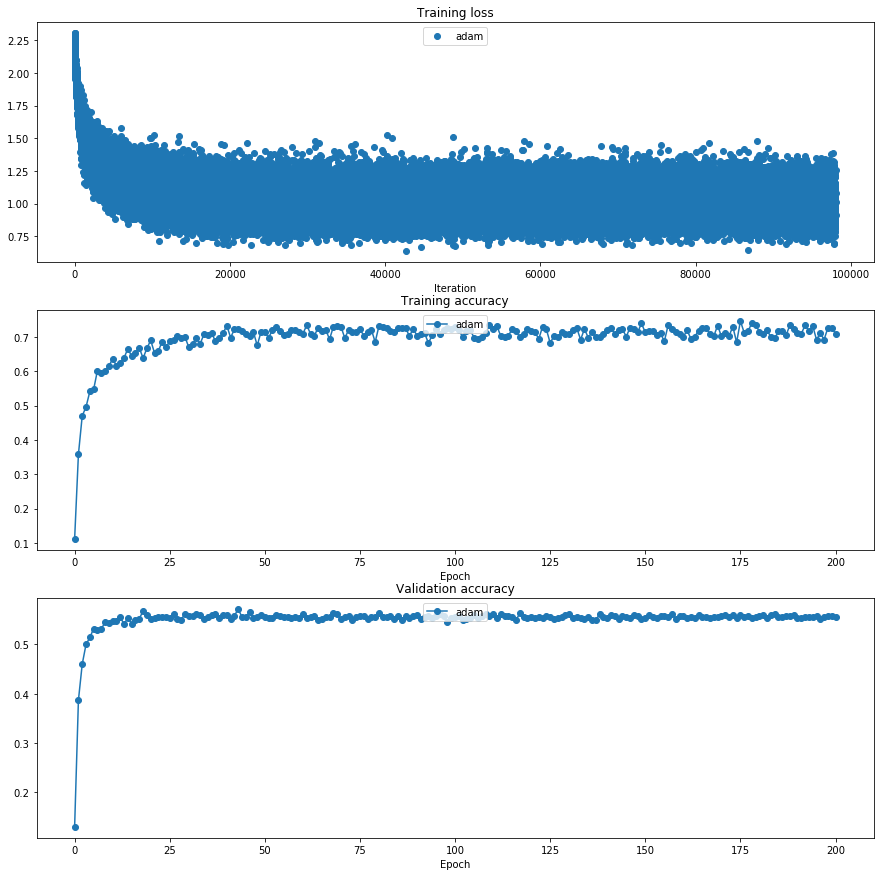

In [9]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

update_rule = 'adam'
plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label=update_rule)

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label=update_rule)

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [11]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.563
Test set accuracy:  0.571
